In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import os

In [3]:
TRAIN_PATH = os.path.join('dogs-cats-images', 'training_set')
TEST_PATH = os.path.join('dogs-cats-images', 'test_set')
cat_img_name = os.listdir(os.path.join(TRAIN_PATH, 'cats'))
dog_img_name = os.listdir(os.path.join(TRAIN_PATH, 'dogs'))
IMG_SIZE = 64

In [4]:
def read_image(name, margin=True, train=True):
    folder = name[:3] + 's'
    if train:
        img_path = os.path.join(TRAIN_PATH, folder, name)
    else:
        img_path = os.path.join(TEST_PATH, folder, name)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if margin:
        MARGIN = 5
        heigth = image.shape[0]
        width = image.shape[1]
        image = image[MARGIN:heigth-MARGIN, MARGIN:width-MARGIN]

    return image

In [5]:
def canny_box_plot(img, plot=True):
    img_box = img.copy()
    edges = cv2.Canny(img, 100, 200)
    
    if edges.sum() == 0:
        print('No edges')
        return img
    
    height_sum = np.sum(edges, axis=1)
    width_sum = np.sum(edges, axis=0)
    row_min = np.where(height_sum > 0)[0][0]
    row_max = np.where(height_sum > 0)[0][-1:][0]
    col_min = np.where(width_sum > 0)[0][0]
    col_max = np.where(width_sum > 0)[0][-1:][0]
    img_box[row_min-10:row_min+10, col_min:col_max] = [0]
    img_box[row_max-10:row_max+10, col_min:col_max] = [0]
    img_box[row_min:row_max, col_min-10:col_min+10] = [0]
    img_box[row_min:row_max, col_max-10:col_max+10] = [0]

    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
        ax[0].imshow(img)
        ax[0].set_title('Original Image', fontsize=24)
        ax[1].imshow(edges)
        ax[1].set_title('Canny Edges', fontsize=24)
        ax[2].imshow(img_box)
        ax[2].set_title('Bounding Box', fontsize=24)
        plt.show()
    
    return img[row_min:row_max, col_min:col_max]

In [6]:
def process_image(image, plot=False):
    image = canny_box_plot(image, plot)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

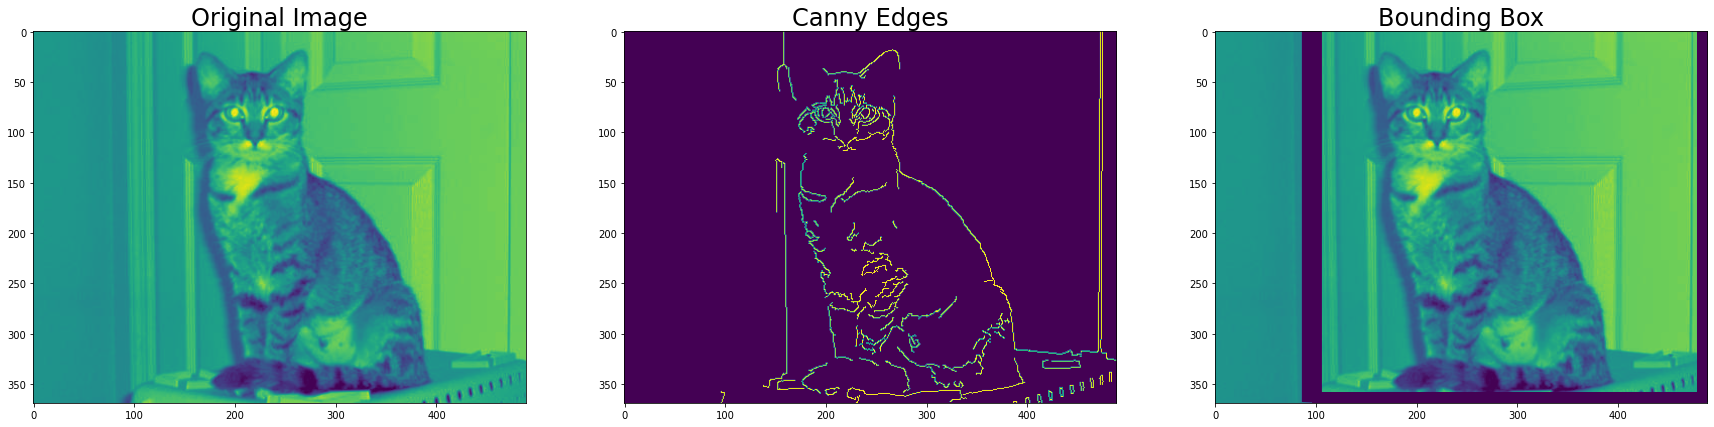

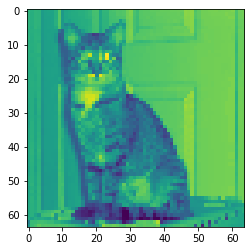

In [7]:
image = read_image(cat_img_name[np.random.randint(4000)])
image = process_image(image, plot=True)
plt.imshow(image)

In [8]:
X = np.array([process_image(read_image(name)) for name in dog_img_name + cat_img_name])
y = np.array([0] * len(dog_img_name) + [1] * len(cat_img_name))
X.shape, y.shape

No edges


((8000, 64, 64), (8000,))

In [9]:
random_state = np.random.randint(1024)
Xt, Xv, yt, yv = train_test_split(X, y, random_state=random_state)
Xt.shape, Xv.shape, yt.shape, yv.shape

((6000, 64, 64), (2000, 64, 64), (6000,), (2000,))

In [10]:
def data_augmentation(X, y):
    Xh = np.array([cv2.flip(img, 1) for img in X])
    X_new = np.concatenate((X, Xh))
    y_new = np.concatenate((y, y))
    return X_new, y_new

In [11]:
Xt, yt = data_augmentation(Xt, yt)
Xt = Xt.reshape(Xt.shape[0], Xt.shape[1], Xt.shape[2], 1)
Xv = Xv.reshape(Xv.shape[0], Xv.shape[1], Xv.shape[2], 1)
Xt.shape, Xv.shape, yt.shape, yv.shape

((12000, 64, 64, 1), (2000, 64, 64, 1), (12000,), (2000,))

In [12]:
model = Sequential([
    L.Conv2D(32, (3, 3), activation='relu', input_shape = (IMG_SIZE, IMG_SIZE, 1)),
    L.MaxPooling2D(pool_size = (2, 2)), 
    L.Conv2D(64, (3, 3), activation='relu'), 
    L.MaxPooling2D(pool_size = (2, 2)), 
    L.Conv2D(128, (3, 3), activation='relu'), 
    L.MaxPooling2D(pool_size = (2, 2)), 
    L.Flatten(),
    L.Dense(units = 128, activation = 'relu'),
    L.Dense(units = 64, activation = 'relu'), 
    L.Dense(units = 32, activation = 'relu'),
    L.Dense(1, activation='sigmoid'),
])

checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(Xt, yt, epochs=20, batch_size=64, validation_data=(Xv, yv), callbacks=[checkpoint])

Train on 12000 samples, validate on 2000 samples
Epoch 1/20
12000/12000 [==============================] - 21s 2ms/sample - loss: 0.8431 - accuracy: 0.5506 - val_loss: 0.7212 - val_accuracy: 0.5865
Epoch 2/20
12000/12000 [==============================] - 23s 2ms/sample - loss: 0.6321 - accuracy: 0.6426 - val_loss: 0.5709 - val_accuracy: 0.7045
Epoch 3/20
12000/12000 [==============================] - 21s 2ms/sample - loss: 0.5546 - accuracy: 0.7150 - val_loss: 0.5171 - val_accuracy: 0.7430
Epoch 4/20
12000/12000 [==============================] - 23s 2ms/sample - loss: 0.4919 - accuracy: 0.7607 - val_loss: 0.5573 - val_accuracy: 0.7430
Epoch 5/20
12000/12000 [==============================] - 27s 2ms/sample - loss: 0.4485 - accuracy: 0.7883 - val_loss: 0.4638 - val_accuracy: 0.7795
Epoch 6/20
12000/12000 [==============================] - 27s 2ms/sample - loss: 0.3811 - accuracy: 0.8264 - val_loss: 0.4760 - val_accuracy: 0.7825
Epoch 7/20
12000/12000 [==============================] -

In [13]:
model = load_model('model.h5')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [15]:
score_t = model.evaluate(Xt, yt, batch_size=64)
score_v = model.evaluate(Xv, yv, batch_size=64)
score_t[1], score_v[1]

2000/2000 [==============================] - 1s 438us/sample - loss: 0.5748 - accuracy: 0.7905


(0.93191665, 0.7905)

In [16]:
cat_img_name_test = os.listdir(os.path.join(TEST_PATH, 'cats'))
dog_img_name_test = os.listdir(os.path.join(TEST_PATH, 'dogs'))

X_test = np.array(
    [process_image(read_image(name, train=False)) 
     for name in dog_img_name_test + cat_img_name_test]
)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
y_test = np.array([0] * len(dog_img_name_test) + [1] * len(cat_img_name_test))
X_test.shape, y_test.shape

((2000, 64, 64, 1), (2000,))

In [17]:
model.evaluate(X_test, y_test, batch_size=64)[1]

2000/2000 [==============================] - 1s 428us/sample - loss: 0.5660 - accuracy: 0.7780


0.778